# SVM and GDA for CIFAR-10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

from scipy.spatial.distance import cdist

# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [2]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing  
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Number of training batches =  352
Number of validation batches =  40
Number of test batches =  79


# Visualize the training data

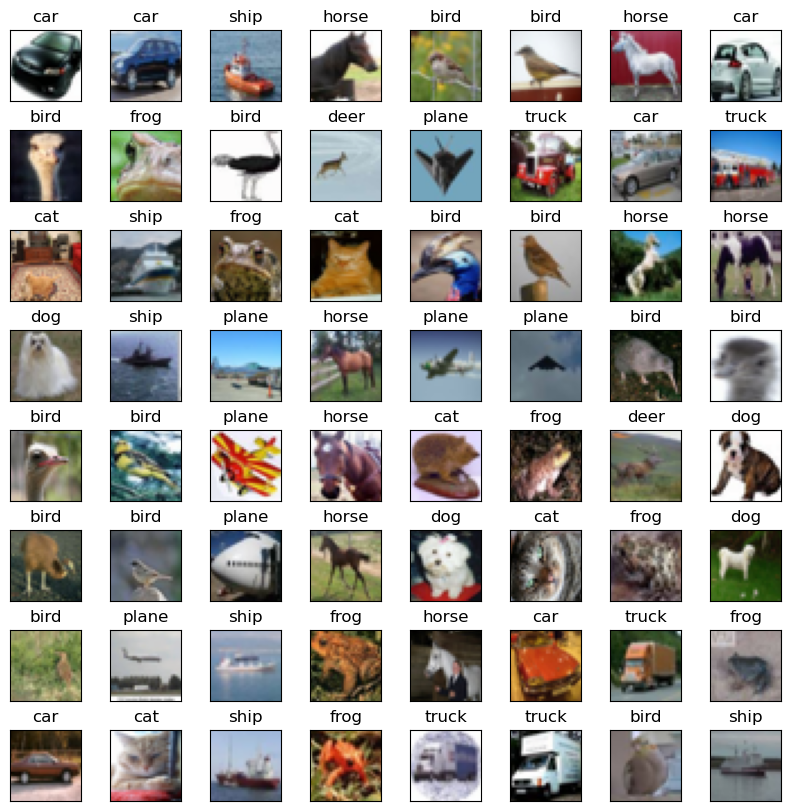

In [3]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# Accumulate the training, validation, and test sets

In [4]:
def extract_data(generator):
    X = torch.zeros((0,3,32,32))
    y = torch.zeros((0,))
    for (Xtr,ytr) in generator:
        X = torch.vstack([X,Xtr])
        y = torch.concat((y,ytr),axis=0)
    return X,y

Xtrain,ytrain = extract_data(trainloader)
print("Training data: ",Xtrain.shape,ytrain.shape)
Xval,yval = extract_data(valloader)
print("Validation data: ",Xval.shape,yval.shape)
Xtest,ytest = extract_data(testloader)
print("Test data: ",Xtest.shape,ytest.shape)

Training data:  torch.Size([45000, 3, 32, 32]) torch.Size([45000])
Validation data:  torch.Size([5000, 3, 32, 32]) torch.Size([5000])
Test data:  torch.Size([10000, 3, 32, 32]) torch.Size([10000])


# GDA with same covariance for each class (5 points)

Set up an LDA model using sklearn's [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) function (10 points)
    
- set up the LinearDiscriminantAnalysis classifier with 'lsqr' solver and store_covariance=True.
- fit this classifier on the training images (flattened into 50000 x 3072) and labels (50000). 
- evaluate the trained model with the set aside test set using built in functions from sklearn.metrics: accuracy, confusion matrix, classification report (f1 scores). Remember to flatten the test images before running the .predict() function.
- visualize the means of the 10 classes, and interpret the images in relation to the classes they represent. 

In [5]:
# concatenate the train and validation sets for GDA
trainX = torch.vstack((Xtrain,Xval))
trainy = torch.cat([ytrain,yval])
print(trainX.shape,trainy.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Accuracy =  0.3713


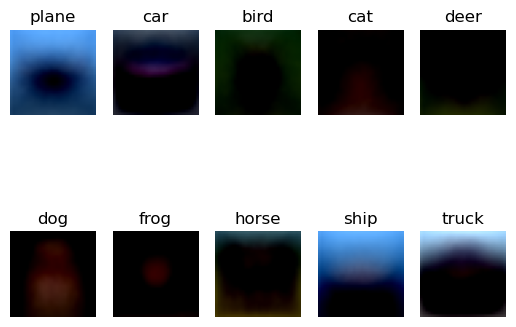

In [6]:
# your code here (LDA model with same covariance for every class)
lda = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)

lda.fit(trainX.view(50000,3072),trainy)

yhat = lda.predict(Xtest.view(10000,3072))
print("Accuracy = ",accuracy_score(ytest,yhat))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    tmp = np.transpose(lda.means_[i].reshape((3,32,32)),(1,2,0))
    plt.imshow(tmp)
    plt.axis('off')
    plt.title(classes[i])



Interpretation of images:
- Plane: Image makes sense as a lot of the planes are in a blue sky and in the center is a darker color representing the figure of the plane.
- Car: The image starts to outline the good of the card which corresponds to car images
- Bird, Cat, Deer, Horse: all of these classes have more variety but the main figure of each of the classes is there.
- Dog: can tell that a dog's face (figure) is close up since a lot of the dog pictures are taken that way
- Ship and Truck: Both are usually on the bottom half of the pictures so that is where the color is darker, while the top of the pictures are lighter since that is where the sky usually is for the pictures.

# Test model on Xtest and ytest (4 points)
- print accuracy of model on (Xtest,ytest)
- print classification report
- print confusion_matrix

In [7]:
#your code here (remember to reshape Xtest)
# about 4 lines
Xtest = Xtest.view(10000,3072)
yhat = lda.predict(Xtest)
print("Accuracy = ",accuracy_score(ytest,yhat))
con_matrix = confusion_matrix(ytest,yhat)
for i in range(len(classes)):
    print(classes[i],end='\t')
    print(con_matrix[i],end='\n')



Accuracy =  0.3713
plane	[463  44  51  43  23  41  22  51 192  70]
car	[ 65 415  44  51  35  46  38  46  80 180]
bird	[102  37 255 101 133  91 137  71  49  24]
cat	[ 43  49 122 245  62 214 132  48  30  55]
deer	[ 61  28 155  82 271 105 146  98  25  29]
dog	[ 37  40 109 179  80 329  89  68  40  29]
frog	[ 13  45 101 139 121  89 413  42  14  23]
horse	[ 50  41  84  72  89  97  46 404  42  75]
ship	[165  81  23  42  11  55  12  21 494  96]
truck	[ 72 183  25  41  29  32  42  61  91 424]


# Visualize the means (1 point)
- comment on the visualizations in this cell. That is, interpret these means in terms of the classes they represent.

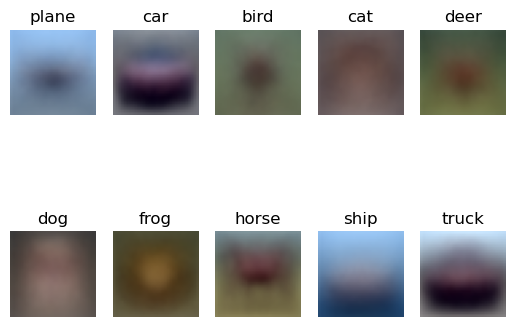

In [8]:
# Run this cell; no code to write.

mean = lda.means_.reshape(10, 32, 32, 3) # 10 x 32 x 32 x 3
class_min, class_max = np.min(lda.means_), np.max(lda.means_)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    tmp = np.transpose(lda.means_[i].reshape((3,32,32)),(1,2,0))
    tmp = (255.0 * (tmp - class_min) / (class_max - class_min)).astype('uint8')
    plt.imshow(tmp)
    plt.axis('off')
    plt.title(classes[i])

plt.show()

# Run SVM on CIFAR10 (40 points)

The sklearn implementation of SVM (SVC) is very slow, because it uses all points in the training set as landmarks. So to speed up the process, we will only use a subset of 5000 images for training.

- build a linear kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train a linear kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build a linear model with that value of C and report accuracy, classification report, and confusion matrix on the full test set. 
- build an RBF kernel SVC model with probability = False and regularization constant C drawn from a set of values C_vals. For each C, train an RBF kernel SVM on the 5000 image training set (sXtrain,sytrain) and measure accuracy on the validation set (Xval,yval). Plot C value vs val set accuracy on a semi-log plot. What is the best value of C for this training set? Build an RBF model with that value of C and report accuracy, classification report, and confusion matrix on the full test set.
- Comment on performance differences between the two models, if any. 

In [9]:
# subselect 5000 examples from the CIFAR-10 dataset
N = 5000
sXtrain = Xtrain[:N]
sytrain = ytrain[:N]
print(sXtrain.shape,sytrain.shape)

torch.Size([5000, 3, 32, 32]) torch.Size([5000])


# Linear SVM kernel
- choosing regularization C using a validation set

In [23]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10])

# your code here for fitting and selecting C (about 6 lines)
c_accuracy = []
for c in C_vals:
    linearSVC = SVC(C=c,kernel='linear',gamma='auto', max_iter=100, probability=False)
    linearSVC.fit(sXtrain.view(5000,3072),sytrain.view(5000,1))
    yhat = linearSVC.predict(Xval.view(5000,3072))
    accuracy = accuracy_score(yval,yhat)
    c_accuracy.append(accuracy)
    print('Done with C = ',c)

/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.0001


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.001


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.01


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.1


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  1.0


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  10.0


[0.2278, 0.2572, 0.2362, 0.243, 0.243, 0.243]
[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


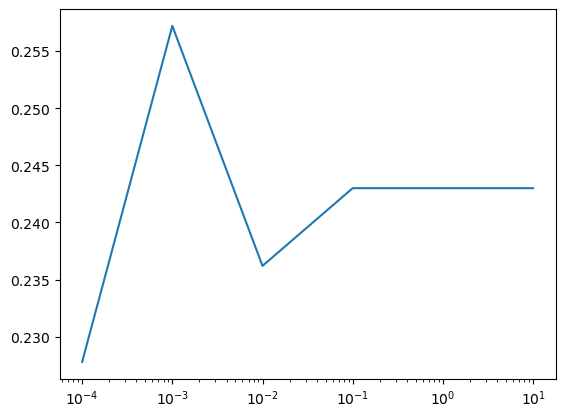

In [24]:
# plot C_vals and val set accuracy in a semilog plot
# 1 line of code
# your code here
print(c_accuracy)
print(C_vals)
plt.semilogx(C_vals,c_accuracy)

In [25]:
# build model with best value of C
# print test accuracy, confusion matrix and classification report on test set
# about 5 lines of code
# your code here
max_accuracy_index = np.argmax(c_accuracy)
linearSVC = SVC(C=C_vals[max_accuracy_index],kernel='linear',gamma='auto', probability=False)
linearSVC.fit(sXtrain.view(5000,3072),sytrain.view(5000,1))
yhat = linearSVC.predict(Xtest.view(10000,3072))
print("Accuracy = ",accuracy_score(ytest,yhat))
print(confusion_matrix(ytest,yhat))
print(classification_report(ytest,yhat,target_names=classes))

/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy =  0.3727
[[504  37  63  32  20  37  26  34 191  56]
 [ 79 424  43  44  17  36  61  32  89 175]
 [133  35 265  95 102  98 140  65  41  26]
 [ 69  64 105 265  58 185 127  47  35  45]
 [ 77  27 179  92 244  96 177  64  22  22]
 [ 58  38 140 184  62 299  90  63  52  14]
 [ 22  33 108 132  73  94 466  32   8  32]
 [ 84  37  99  92 101  84  51 355  29  68]
 [198  70  25  42  14  35   8  21 494  93]
 [100 179  29  37  18  30  47  52  97 411]]
              precision    recall  f1-score   support

       plane       0.38      0.50      0.43      1000
         car       0.45      0.42      0.44      1000
        bird       0.25      0.27      0.26      1000
         cat       0.26      0.27      0.26      1000
        deer       0.34      0.24      0.29      1000
         dog       0.30      0.30      0.30      1000
        frog       0.39      0.47      0.42      1000
       horse       0.46      0.35      0.40      1000
        ship       0.47      0.49      0.48      1000
       tr

# RBF SVM kernel
- choosing regularization C using a validation set

In [28]:
C_vals = np.array([0.0001,0.001,0.01,0.1,1,10,100])

# your code here for finding good value of C for RBF kernel
# about 6 lines
c_accuracy = []
for c in C_vals:
    svc = SVC(C=c,kernel='rbf',gamma='auto', probability=False, max_iter=100)
    svc.fit(sXtrain.view(5000,3072),sytrain.view(5000))
    yhat = svc.predict(Xval.view(5000,3072))
    accuracy = accuracy_score(yval,yhat)
    c_accuracy.append(accuracy)
    print('Done with C = ',c)

/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.0001


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.001


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.01


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  0.1


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  1.0


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  10.0


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done with C =  100.0


[0.2682, 0.2698, 0.2742, 0.3066, 0.3636, 0.35, 0.34]
[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


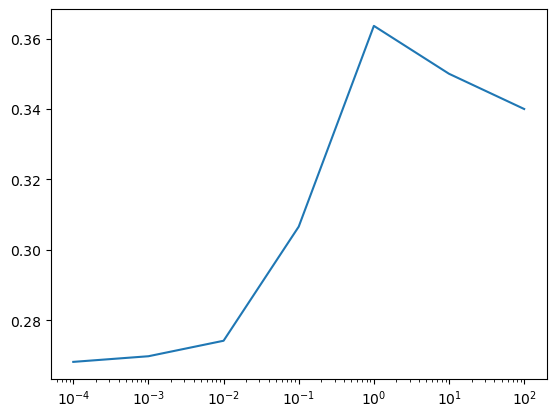

In [29]:
print(c_accuracy)
print(C_vals)
plt.semilogx(C_vals,c_accuracy)

In [30]:
# your code here
# build best RBF model with best value of C
# report test set accuracy, confusion matrix and classification report on test set
# about 6 lines of code
max_accuracy_index = np.argmax(c_accuracy)
svc = SVC(C=C_vals[max_accuracy_index],kernel='rbf',gamma='auto')
svc.fit(sXtrain.view(5000,3072),sytrain.view(5000,1))
yhat = svc.predict(Xtest.view(10000,3072))
print("Accuracy = ",accuracy_score(ytest,yhat))
print(confusion_matrix(ytest,yhat))
print(classification_report(ytest,yhat,target_names=classes))


/Users/marcolagos/anaconda3/envs/asml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy =  0.434
[[506  33  68  17  31  20  37  32 209  47]
 [ 53 490  16  41  18  32  56  27  71 196]
 [109  29 286  86 145  64 168  49  37  27]
 [ 49  50  78 263  55 209 142  55  37  62]
 [ 60  24 154  67 331  60 194  62  29  19]
 [ 29  31 102 188  65 352 113  54  36  30]
 [ 16  25  81  68  98  78 567  24  10  33]
 [ 49  44  65  75  97  86  75 400  28  81]
 [101  71  21  17  20  39  19  20 614  78]
 [ 51 155  15  40  14  18  37  40  99 531]]
              precision    recall  f1-score   support

       plane       0.49      0.51      0.50      1000
         car       0.51      0.49      0.50      1000
        bird       0.32      0.29      0.30      1000
         cat       0.31      0.26      0.28      1000
        deer       0.38      0.33      0.35      1000
         dog       0.37      0.35      0.36      1000
        frog       0.40      0.57      0.47      1000
       horse       0.52      0.40      0.45      1000
        ship       0.52      0.61      0.57      1000
       tru

# Comment on linear SVM vs RBF kernel SVM
- The RBF kernel SVM has an accuracy of approx 0.434, while the linear SVM has an accuracy of approx 0.3727. RBF kernel SVM is therefore more accurate at classifying these images. Looking at both of the models, the RBF kernel SVM has a higher precision than the linear SVM. This could be a result of RBF kernel SVM being able to capture more complex and nonlinear relationships between the input and target variables than the linear SVM.
- While the linear SVM was faster computationally wise, the RBF kernel SVM was always going to be at least as accurate as the linear model.